In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("./assignment1.ipynb")

# Assignment 1: 2018 US House Elections

## Direction and Goal

![election_prediction](images/clinton-trump-rating.png)  
[image credit](https://donsnotes.com/politics/images/clinton-trump-rating.png)

We haven't talked about predictive models, but we can still think about what makes a "good" prediction.  In this assignment, we'll focus on evaluating the quality of election predictions made by the website [fivethirtyeight.com](https://www.fivethirtyeight.com).  As one prominent example, fivethirtyeight predicted that Clinton had a 70.9% chance to win the election.  Was their model wrong?

To gain insight into questions like this, we'll focus on  [US House elections predictions from 2018](https://projects.fivethirtyeight.com/2018-midterm-election-forecast/house/).  Their predictions are based predominantly on polling data but include other sources as well (state of the economy, overall favoriability of politic parties, etc).  

This homework is based loosely on [this article](https://projects.fivethirtyeight.com/checking-our-work/).  Please read the article before beginning the assignment.

## Question 1: Data Processing

### Download Data
Command line interface is a useful tool for programmatically interacting with general functions of your computer: e.g. manipulate/manage files, download from the internet, run scripts, etc.

We will get acquainted with command line soon, but below uses command line interace commands to download the raw CSV file from [fivethirtyeight's github page for this data](https://github.com/fivethirtyeight/checking-our-work-data/blob/master/us_house_elections.csv). The `!` mark tells Jupyter notebook that the command following it is to be evaluated as a command line code.

In [4]:
!wget -nc https://raw.githubusercontent.com/fivethirtyeight/checking-our-work-data/master/us_house_elections.csv  -O us_house_elections.csv

File ‘us_house_elections.csv’ already there; not retrieving.


In [5]:
!ls -l *.csv ## `ls` command verify that data is downloaded in our folder

-rw-rw-r-- 1 exouser exouser 41999837 Oct 23 21:50 us_house_elections.csv


### Read Data into Python

Numpy and Pandas is used to read in the csv file into python.

In [2]:
import pandas as pd
import numpy as np

# Monkeypatch Pandas' .any and .all methods to always return Python bools
pd.Series.any = lambda self, *args, **kwargs: bool(super(pd.Series, self).any(*args, **kwargs))
pd.Series.all = lambda self, *args, **kwargs: bool(super(pd.Series, self).all(*args, **kwargs))
election_data = pd.read_csv("us_house_elections.csv", low_memory=False)

if not hasattr(np, "_old_round"):
    np._old_round = np.round

    def _np_round(a, *args, **kwargs):
        result = np._old_round(a, *args, **kwargs)
        if np.isscalar(result):
            return float(result)
        return result

    np.round = _np_round

Add column of zeros named `bin` to `election_data` (we will populate this column with meaningful data later) and `print` the first 10 rows of the `DataFrame` using `iloc`.

In [3]:
election_data['bin'] = 0
print(election_data.iloc[:10,])

   year office state  district election_date forecast_date forecast_type  \
0  2022  House    WY       1.0    2022-11-08    2022-11-08          lite   
1  2022  House    WY       1.0    2022-11-08    2022-11-08          lite   
2  2022  House    WV       2.0    2022-11-08    2022-11-08          lite   
3  2022  House    WV       2.0    2022-11-08    2022-11-08          lite   
4  2022  House    WV       1.0    2022-11-08    2022-11-08          lite   
5  2022  House    WV       1.0    2022-11-08    2022-11-08          lite   
6  2022  House    WI       8.0    2022-11-08    2022-11-08          lite   
7  2022  House    WI       7.0    2022-11-08    2022-11-08          lite   
8  2022  House    WI       7.0    2022-11-08    2022-11-08          lite   
9  2022  House    WI       6.0    2022-11-08    2022-11-08          lite   

  party            candidate  projected_voteshare  actual_voteshare   probwin  \
0     D    Lynnette GreyBull             30.15680         24.367980  0.000825   
1

Fivethirtyeight has three different prediction models: `lite`, `classic` and `deluxe`, which roughly incorporate an increasing number of assumptions.  In this assignment lets focus on evaluting the quality of the `classic` predictions.  You can read more about how the prediction models work [here](https://fivethirtyeight.com/methodology/how-fivethirtyeights-house-and-senate-models-work/).

Fivethirtyeight continuously updated their predictions as more polling data became available for each of the races.  Let's focus on the predictions a few months before the election, on August 11th, and on the morning of election day, November 6th.  

### Question 1a: Subset Data

Create a new pandas dataframe called `election_sub` by filtering to include only rows in which the `forecast_type` is "classic", and the date of the foreceast (`forecast_date`) is 8/11 or 11/6. 

Using `query` method seems well-suited.  Note you can make two (or more) calls to `query` by chaining calls to `query` like this: `election_data.query(...).query(...)`. Output of one query will be used as an input to the second query.

In [4]:
# Fill-in ...
# Keep all columns using .loc (not .query)
election_sub = election_data.loc[
    (election_data['forecast_type'] == 'classic') &
    (election_data['forecast_date'].isin(['2018-08-11', '2018-11-06']))
]

# Remove NaN candidates and ensure each has two predictions
election_sub = election_sub[election_sub['candidate'].notna()]
election_sub = election_sub.groupby('candidate').filter(lambda x: len(x) == 2)


In [5]:
grader.check("q1a")

q1a results: All test cases passed!

### Question 1b: Filtering Data

In previous question, data was subset for two forcast dates: 2018-11-06 and 2018-08-11. Presumably, there _should be_ two rows (predictions) for each candidate; however, you will see that some candidates are missing one of the two predictions and not all name entries are valid.

Using Pandas, remove any NaN names and any candidate that does not have two predictions.

Finally, overwrite `election_sub` with the filtered data.

There are different ways of doing this. I found the following functions useful:

* [`pandas.DataFrame.isnull`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.isnull.html)
* [`pandas.DataFrame.groupby`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html)
* [`pandas.core.groupby.DataFrameGroupBy.filter`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.core.groupby.DataFrameGroupBy.filter.html)
* [`pandas.DataFrame.shape`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.shape.html)

When using the documentation, make sure to use the correct version. You can check by running `pd.__version__`.

In [6]:
# Subset to two forecast dates
election_sub = election_data.query(
    "forecast_type == 'classic' and forecast_date in ['2018-08-11', '2018-11-06']"
)

# Remove NaN candidates
election_sub = election_sub[election_sub['candidate'].notna()]

# Keep only candidates with exactly two predictions
election_sub = election_sub.groupby('candidate').filter(lambda x: len(x) == 2)


In [7]:
grader.check("q1b")

q1b results: All test cases passed!

### Question 1c: Transform Data

We want to check whether events predicted by 538 to occur with probability _close to_ X% actually occured about X% of the time.  To do this, we have to define _close_.

First, we'll define the `cut_points` as 20 equally spaced numbers between 0 and 1 using `np.linspace`.  Then we'll group the predicted probabilities into the `19` equally spaced bins determined by those cut points.  Define the bin for each observation using the `pd.cut` function on the `probwin` variable.  Then, assign the result to column `bin` of `election_sub`. Use `include_lowest=True` when calling `pd.cut`.

_Note: Can you spot the strange behavior of `include_lowest=True`? [Despite the output, `pd.cut` seems to work correctly](https://github.com/pandas-dev/pandas/issues/23164#issuecomment-510700455)_

In [8]:
cut_points = np.linspace(0, 1, 20)
election_sub['bin'] = pd.cut(election_sub['probwin'], cut_points, include_lowest=True)

In [9]:
grader.check("q1c")

q1c results: All test cases passed!

## Question 2: Looking for Insights

### Question 2a: Calculate Change in Support

Let's see if we can find the candidates whose standings change the most between August 11 and November 6: one with largest improvement and another with largest decrease in win-probability. First, use the `agg` function calculate the difference.

Following functions have been useful for me:

* [`numpy.diff`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.diff.html)
* [`pandas.DataFrame.sort_values`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sort_values.html)
* [`pandas.DataFrame.groupby`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html)
* [`pandas.DataFrame.agg`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.agg.html): especially, [different functions to columns](https://pandas.pydata.org/pandas-docs/stable/user_guide/groupby.html#applying-different-functions-to-dataframe-columns) 

Save the resulting DataFrame from `agg()` to a variable, `probwin_change`.

In [10]:
probwin_change = (
    election_sub
    .sort_values(by=['candidate', 'forecast_date'])
    .groupby('candidate')
    .agg({'probwin': lambda x: np.diff(x).item()})
)

# Convert column to float explicitly
probwin_change['probwin'] = probwin_change['probwin'].astype(float)


In [11]:
grader.check("q2a")

q2a results: All test cases passed!

### Question 2b: Looking for Largest Changes

Now, save the name of the candidates to string variables `rising_candidate` (largest increase) and `falling_candidate` (largest decrease).

* [`pandas.DataFrmae.idxmax`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.idxmax.html)
* [`pandas.DataFrmae.idxmin`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.idxmin.html)

In [12]:
rising_candidate = probwin_change['probwin'].idxmax()
falling_candidate = probwin_change['probwin'].idxmin()

In [13]:
grader.check("q2b")

q2b results: All test cases passed!

<!-- BEGIN QUESTION -->

### Question 2c: Verify Outcome

Did the candidate win or lose the election? Verify with election outcome.

**SOLUTION**

To check that we can look at the outcome from the question above. And from the code below we can see that the rising candidate won whereas the falling candidate lost.

In [14]:
# Check the outcome for the rising candidate
rising_outcome = election_sub[election_sub['candidate'] == rising_candidate]['probwin_outcome'].iloc[0]
print(f"{rising_candidate} - Rising candidate outcome: {'Won' if rising_outcome == 1 else 'Lost'}")

# Check the outcome for the falling candidate
falling_outcome = election_sub[election_sub['candidate'] == falling_candidate]['probwin_outcome'].iloc[0]
print(f"{falling_candidate} - Falling candidate outcome: {'Won' if falling_outcome == 1 else 'Lost'}")

Sharice Davids - Rising candidate outcome: Won
Kevin Yoder - Falling candidate outcome: Lost


<!-- END QUESTION -->

## Prediction vs Actual Outcomes

<!-- BEGIN QUESTION -->

### Question 3a: Prediction Histogram

Make a histogram showing the predicted win probabilities _on the morning of the election._  Again, restrict yourself to only the `classic` predictions.

In [15]:
!pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable


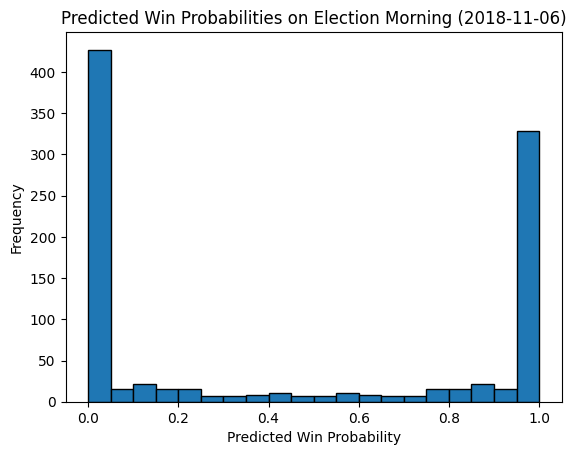

In [16]:
import matplotlib.pyplot as plt

# Filter for classic predictions on the morning of the election (2018-11-06)
election_morning = election_data[(election_data['forecast_type'] == 'classic') & 
                                  (election_data['forecast_date'] == '2018-11-06')]

# Create histogram of predicted win probabilities
plt.hist(election_morning['probwin'], bins=20, edgecolor='black')
plt.xlabel('Predicted Win Probability')
plt.ylabel('Frequency')
plt.title('Predicted Win Probabilities on Election Morning (2018-11-06)')
plt.show()

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 3b: Prediction difficulty 

Are most house elections easy to forecast or hard to forecast? State your reasoning.

**SOLUTION**

It looks like a bimodial where the peaks are at 0 and 1 with very few predictions in the middle. Thus, most house elections are easy to predict. The histogram shows that the majority of predicted win probabilities cluster at the extremes - either very close to 0 (almost certain to lose) or very close to 1 (almost certain to win). There are relatively few races with probabilities in the middle range (0.3-0.7), which would indicate competitive/uncertain races. This bimodal distribution suggests that FiveThirtyEight's model was highly confident in most races. 

<!-- END QUESTION -->

### Question 4a: Compute Actual Outcomes

Now we've grouped the observations into a discrete set of bins according to the predicted probability, `probwin`.  Within each bin, we now want to compute the actual fraction of times the candidates won.

If 538 did a good job, it will be close to the predited probabilities.  You'll need to use the `groupby` function to compute the mean of `probwin_outcome` (1 is a win and 0 is a loss) within each bin. Once again you can use `agg` method here.  

Save the fraction of actual wins in each bin in a list called `fraction_outcome`.

In [18]:
fraction_outcome = (
    election_sub
    .assign(bin=lambda x: x['bin'].apply(lambda b: b.mid))
    .groupby('bin')['probwin_outcome']
    .mean()
    .to_frame()
)

fraction_outcome.iloc[0] < fraction_outcome.iloc[-1]
# probwin_outcome    True
# dtype: bool

np.round(fraction_outcome.sum(), 3)
# probwin_outcome    9.5
# dtype: float64



/tmp/ipykernel_293047/1322858068.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('bin')['probwin_outcome']


probwin_outcome    9.5
dtype: float64

In [19]:
grader.check("q4a")

q4a results: All test cases passed!

### Question 4b: Preparing to Present Results

For this problem we'll make a plot of the predicted probabilities and actual fraction of wins in each bin.  We've already computed the actual fraction of wins; all that remains is to plot it against the predicted value assocaited with each bin.

For the predicted value in each bin, using the midpoint of the bin would make sense.  Compute the midpoints of each bin from `cut_points`.

In [20]:
midpoints = (cut_points[:-1] + cut_points[1:]) / 2

In [21]:
grader.check("q4b")

q4b results: All test cases passed!

<!-- BEGIN QUESTION -->

### Question 4c: Visualize Results

Now make a scatterplot using `midpoints` as the x variable and `fraction_outcome` as the y variable.  Draw a dashed line from `[0,0]` to `[1,1]` to mark the line y=x.  

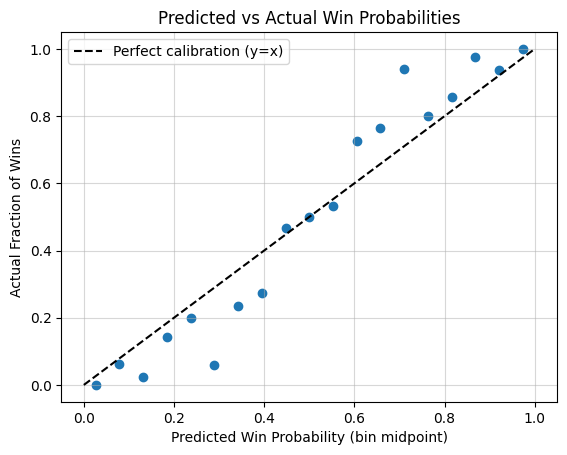

In [22]:
# magic for showing figures inline
%matplotlib inline 
import matplotlib.pyplot as plt

# Create scatterplot
plt.scatter(midpoints, fraction_outcome)

# Draw y=x reference line (dashed)
plt.plot([0, 1], [0, 1], 'k--', label='Perfect calibration (y=x)')

# Labels and formatting
plt.xlabel('Predicted Win Probability (bin midpoint)')
plt.ylabel('Actual Fraction of Wins')
plt.title('Predicted vs Actual Win Probabilities')
plt.legend()
plt.grid(True, alpha=0.5)
plt.show()


<!-- END QUESTION -->

## Quantifying Uncertainty

### Question 5a: Model-based Error Estimation

If you did things correctly, it should look like fivethirtyeight has done "pretty" well with their forecasts: the actual fraction of wins tracks closely with the predicted number.

But how do we decide what's "good enough"? Consider this example: I correctly predict that a coin is fair (e.g. that it has a 50% chance of heads, 50% chance of tails).  But if I flip it 100 times, I can be pretty sure it won't come up heads exactly 50 times.  The fact that heads didn't come up exactly 50 times doesn't make my prediction incorrect.

To assess how reasonable the predictions are, I need to quantify the uncertainty in my estimate.  It's reasonable to assume that within each bin, $k$, the observed number of wins, $Y_k \sim \text{Binomial}\,(n_k, p_k)$, where $n_k$ is the number of elections and $p_k$ is the predicted win probability in bin $k$.

Classical results tell us that the obseved fraction of wins in bin $k$, $\hat p = \frac{Y_k}{n_k}$ has variance $\operatorname{Var}\left(\hat p_k\right) = \frac{p_k (1-p_k)}{n_k} \approx \frac{\hat p_k(1- \hat p_k)}{n_k}$.  The standard deviation of the Binomial proportion then is $\hat \sigma_k \approx \sqrt{\frac{\hat p_k(1- \hat p_k)}{n_k}}$.  

If we use the [normal approximation to generate a confidence interval](https://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval#Normal_approximation_interval), then the 95% interval has the form $\hat p_k \pm 1.96 \hat \sigma_k$.

Create a new "aggregated" dataframe named `election_agg`.  Take `election_sub`, group by `bin` and compute both the average of the `probwin_outcome` (`mean`) and the number of observations in each bin (`count`) using the `agg` function.  Call this new data frame, `election_agg`.

THen, use the `mean` and `count` columns of `election_agg` to create a new column of `election_agg` titled `err`, which stores $1.96 \times \hat \sigma_k$ in each bin $k$.

In [23]:
election_agg = election_sub.groupby('bin').agg({'probwin_outcome': ['mean', 'count']})
election_agg.columns = ['mean', 'count']
election_agg['err'] = 1.96 * np.sqrt((election_agg['mean'] * (1 - election_agg['mean'])) / election_agg['count'])

/tmp/ipykernel_293047/2289722683.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  election_agg = election_sub.groupby('bin').agg({'probwin_outcome': ['mean', 'count']})


In [24]:
grader.check("q5a")

q5a results: All test cases passed!

<!-- BEGIN QUESTION -->

### Question 5b: Visualize Error Bars 1

Use `plt.errorbar` to create a new plot with error bars associated with the actual fraction of wins in each bin.  Again add a dashed y=x line.  Set the argument `fmt='.'` to create a scatterplot with errorbars.

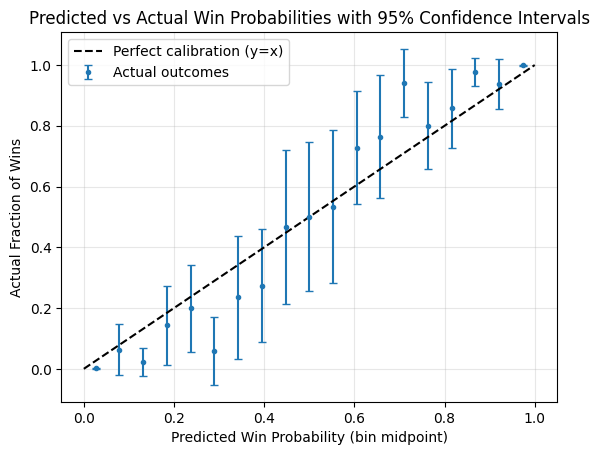

In [26]:
# Plotting code below
# Create scatterplot with error bars
plt.errorbar(midpoints, fraction_outcome['probwin_outcome'], yerr=election_agg['err'], fmt='.', capsize=3, label='Actual outcomes')

# Draw y=x reference line (dashed)
plt.plot([0, 1], [0, 1], 'k--', label='Perfect calibration (y=x)')

# Labels and formatting
plt.xlabel('Predicted Win Probability (bin midpoint)')
plt.ylabel('Actual Fraction of Wins')
plt.title('Predicted vs Actual Win Probabilities with 95% Confidence Intervals')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

<!-- END QUESTION -->

### Question 5c: Computing Coverage

If our intervals were true 95% confidence intervals, then we would expect about 95% of them to cover the midpoint of the bin (i.e. overlap with the y=x line).

What fraction of the 95% confidence intervals cover the bin midpoint?  Create a variable, `upper`, to be the `mean` + `err` and another, `lower`, to be `mean` - `err` (both `upper` and `lower` should pandas series). Next, compute `frac_covering` as the fraction of midpoints between `lower` and `upper`. 

In [28]:
upper = election_agg['mean'] + election_agg['err']
lower = election_agg['mean'] - election_agg['err']

frac_covering = ((midpoints >= lower) & (midpoints <= upper)).mean()
frac_covering = float(frac_covering)

In [29]:
grader.check("q5c")

q5c results: All test cases passed!

<!-- BEGIN QUESTION -->

### Question 5d: Understanding Confidence Intervals

Are the 95% confidence intervals generally larger or smaller for more confident predictions (e.g. the predictions closer to 0 or 1).  What are the factors that determine the length of the confidence intervals?

**SOLUTION**

The intervals are smaller because the formula shows that variance is maximized when $\hat{p} = 0.05$ and minimized when it approaches 0 or 1. Other factors that matter are sample size, the larger the sample size the smaller the intervals because you get less varainces when sample size are large. 

<!-- END QUESTION -->

_Intentionally Blank_

### Question 5e: Empirical Uncertainty Estimation

Model-based error bars were calculated by assuming that election outcomes are Binomial random variables. However, we can also estimate the error bars from resampling the data. This can be useful if we do not have a good distributional about the election outcomes, for example.

Write a function named `bootstrap_data_means` that can take a data frame, say `data_in`, as input. Suppose `data_in` has `n` rows. Inside `bootstrap_data_means` function, you will

* [`numpy.random.Generator.choice`](https://docs.scipy.org/doc/numpy/reference/random/generated/numpy.random.Generator.choice.html?highlight=random%20choice#numpy.random.Generator.choice): Select `n`-rows of `data_in` at random _with replacement_, creating a pseudo-dataset
* `agg`: Group by each `bin`, compute probabilities of success for each pseudo-dataset as you have done


Then, run the function `bootstrap_data_means` function 100 times, storing the resulting 100 DataFrames in a list. Then, create a data frame `bootstrap_election_100_agg` using `pandas.concat`:

* Python list comprehension: https://docs.python.org/3/tutorial/datastructures.html#list-comprehensions
* [`pandas.concat`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.concat.html): Concatenate many DataFrames together.  
    Especially, the example, _Combine two DataFrame objects with identical columns._, in https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.concat.html could be helpful.

In [30]:
def bootstrap_data_means(data_in):
    n = len(data_in)

    # sample WITH replacement
    indx = np.random.choice(n, size=n, replace=True)

    # pseudo-dataset
    pseudo_data = data_in.iloc[indx]

    # group by bin, compute mean
    bootstrap_means = (
        pseudo_data
        .groupby('bin')['probwin_outcome']
        .mean()
        .to_frame(name='probwin_outcome')   # ensure it's a DataFrame, not Series
    )

    return bootstrap_means

bootstrap_election_100_agg = pd.concat(
    [bootstrap_data_means(election_sub) for _ in range(100)],
    axis=1
)



/tmp/ipykernel_293047/1732487252.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('bin')['probwin_outcome']


In [31]:
grader.check("q5e")

q5e results: All test cases passed!

<!-- BEGIN QUESTION -->

### Question 5f. Visualize Error Bars 2

By now, we have a distribution of success probabilities saved in `bootstrap_election_agg`. We can compute empirical error bars from 2.5% and 97.5% quantiles. Write function named `bootstrap_error_bars` that can be used to calculate the following columns:

* `mean`: mean of probabilities of success
* `err_low`: low point of the error bars
* `err_high`: high point of the error bars

Funtion `bootstrap_error_bars` is to be called by using `bootstrap_election_100_agg.apply(bootstrap_error_bars, ...)`.

In [32]:
def bootstrap_error_bars(x):
    out = pd.Series([x.mean(), x.mean()-x.quantile(0.025), x.quantile(0.975)-x.mean()], 
                    index=['mean', 'err_low', 'err_high'])
    return(out)

Use [`pandas.DataFrame.apply`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.apply.html) and `bootstrap_error_bars` functions to calculate and visualize the error bars.

In addition, to the figure code used in 5b, add horizontal lines at 0 and 1.

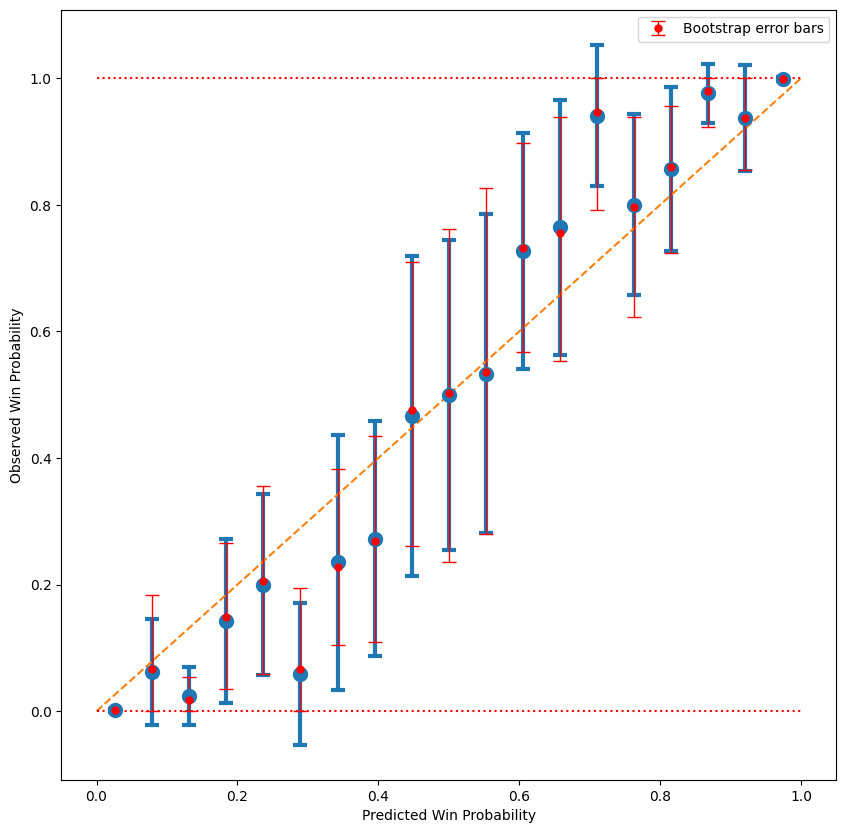

In [33]:
# calculate error bars
bootstrap_election_agg = bootstrap_election_100_agg.apply(bootstrap_error_bars, axis=1)

plt.figure(figsize=(10, 10))
plt.errorbar(midpoints, 
             election_agg['mean'].values, 
             yerr=election_agg['err'].values, 
             fmt='.', elinewidth=3, ms=20, 
             capsize=5, capthick=3)
plt.plot([0, 1], [0, 1], '--')
plt.plot([0, 1], [1, 1], ':r')
plt.plot([0, 1], [0, 0], ':r')
plt.xlabel("Predicted Win Probability")
plt.ylabel("Observed Win Probability")
# Overlay empirical error bars on the same plot. Use the following 
# visual attributes: 
# ..., fmt='.r', elinewidth=1, ms=10, ecolor='red', capsize=5, ...
# Also, yerr can accept asymmetric errorbars (see the documentation for usage)
plt.errorbar(midpoints, 
             bootstrap_election_agg['mean'].values, 
             yerr=[bootstrap_election_agg['err_low'].values, 
                   bootstrap_election_agg['err_high'].values],
             fmt='.r', elinewidth=1, ms=10, ecolor='red', capsize=5, 
             label='Bootstrap error bars')
plt.legend()
plt.show()

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 5g: Interpreting the Results

Are the 95% confidence intervals generally larger or smaller for more confident predictions (e.g. the predictions closer to 0 or 1).  What are the factors that determine the length of the error bars?

Compare and contrast model-based error bars and empirically obtained error bars. What are the advantages and disadvantages of these two approaches?

**SOLUTION:**

As said in the earlier question the confidence interval are smaller for more confident predictions i.e. predictions closer to 0 or 1. The factors that determine that is the predicted probability and the sample size. Some advantages of model-bassed (blue bars) that is it is based on statistical theory, it requires less data points, and it provides nice symmetric intervals. Some disadvantanges are that they assume binomal distribution is correct, and some uncertinity in the distribution might not be captured. Also needs sufficient sample size to rely on normal approximation. The bootstrap or empirical (red bars) advantages are that it makes no assumptions, captures the variability in size, it can handle non symmetric distributions and should be more robust. That being said, the disadvantages are that it could be computationally intensive and because random resampling is involved the results can vary between different runs. It also requires sufficient office hours 

<!-- END QUESTION -->

_Intentionally Blank_

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [34]:
!sudo apt-get install pandoc -y

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
pandoc is already the newest version (2.9.2.1-3ubuntu2).
0 upgraded, 0 newly installed, 0 to remove and 0 not upgraded.


In [27]:
# Save your notebook first, then run this cell to export your submission.
grader.export(pdf=False, run_tests=False)